In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as fn
import torch.optim as optim

from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.metrics import accuracy_score, f1_score
from torchvision import datasets, transforms
from tqdm.auto import tqdm

import models

In [2]:
import importlib
importlib.reload(models)

<module 'models' from '/home/mma6789/Stuff/Studies/sem4/fmse/project/models.py'>

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

# Set random seed for reproducibility
torch.manual_seed(42)

Using device: cuda
Quadro RTX 6000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
base_dir = '/home/mma6789/Stuff/Studies/sem4/fmse/project' #@param {type: 'string'}

In [5]:
epsilon_range = [0, .05, .1, .15, .2, .25, .3]
pretrained_CNN = f'{base_dir}/models/MNIST_CNN_0.001.pt'

In [6]:
# Load MNIST train and test dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(f'{base_dir}/data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=32, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(f'{base_dir}/data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=32, shuffle=True)

In [7]:
# Initialize pretrained model
model = models.CNN().to(device)
model.load_state_dict(torch.load(pretrained_CNN, map_location=device))

<All keys matched successfully>

In [8]:
# perturb batch of images
def perturb_batch(batch, epsilon, grad_batch):
    sign_grad_batch = grad_batch.sign()
    perturbed_batch = batch + epsilon * sign_grad_batch
    perturbed_batch = torch.clamp(perturbed_batch, 0, 1)
    
    return perturbed_batch

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [9]:
def train_epoch(eps):
    model.train(True)
    running_loss = 0.0
    y_true = []
    y_pred = []

    for batch_index, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1} train')):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        x_batch.requires_grad = True
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        
        model.zero_grad()
        loss.backward()
        grad_batch = x_batch.grad.data
        
        x_batch_denorm = denorm(x_batch)
        x_batch_perturb = perturb_batch(x_batch_denorm, eps, grad_batch)
        x_batch_perturb_norm = transforms.Normalize((0.1307,), (0.3081,))(x_batch_perturb)

        output = model(x_batch_perturb_norm)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        y_true += y_batch.flatten().tolist()
        y_pred += torch.argmax(output, dim=1).cpu().detach().numpy().tolist()
        
        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()

    avg_batch_loss = running_loss / len(train_loader)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    train_loss.append(avg_batch_loss)
    train_acc.append(acc)
    train_f1.append(f1)
    
    print('Train epoch results:')
    print(f'Loss: {avg_batch_loss}')
    print(f'Acc: {acc}')
    print(f'F1: {f1}')

In [10]:
def test_epoch(eps):
    model.train(False)
    running_loss = 0.0
    y_true = []
    y_pred = []
    eps_samples = []
    
    for batch_index, batch in enumerate(tqdm(test_loader, desc=f'Epsilon {eps}')):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        x_batch.requires_grad = True
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        
        model.zero_grad()
        loss.backward()
        grad_batch = x_batch.grad.data
        
        x_batch_denorm = denorm(x_batch)
        x_batch_perturb = perturb_batch(x_batch_denorm, eps, grad_batch)
        x_batch_perturb_norm = transforms.Normalize((0.1307,), (0.3081,))(x_batch_perturb)
        
        with torch.no_grad():
            output = model(x_batch_perturb_norm)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
        
        y_true += y_batch.flatten().tolist()
        y_pred += torch.argmax(output, dim=1).cpu().detach().numpy().tolist()
        
        for i in range(len(batch[0])):
            sample = (y_true[i + batch_index * 32], y_pred[i + batch_index * 32], x_batch_perturb[i].squeeze().detach().cpu().numpy(), x_batch_perturb_norm[i])
            eps_samples.append(sample)

    avg_batch_loss = running_loss / len(test_loader)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    test_loss.append(avg_batch_loss)
    test_acc.append(acc)
    test_f1.append(f1)
    samples.append(eps_samples)
    
    print('Test epoch results:')
    print(f'Loss: {avg_batch_loss}')
    print(f'Acc: {acc}')
    print(f'F1: {f1}')

In [11]:
def eval_img_explaination(images):
    model.train(False)
    
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    batch = torch.stack(tuple(transformer(i[:, :, 0]) for i in images), dim=0)
    
    batch = batch.to(device)
    output = model(batch)
    probs = [torch.exp(i).detach().cpu().numpy() for i in output]
    
    return probs

def get_explaination(sample):
    y_true, y_pred, img, img_norm = sample
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(np.array(img), eval_img_explaination, hide_color=0, num_samples=1000)
    
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=100, hide_rest=False)
    img_boundry = mark_boundaries(temp/255.0, mask)
    plt.imshow(img_boundry)

In [12]:
## Model Parameters
learning_rate = 0.001
epochs = 10
epsilon = 0.3

loss_function = nn.NLLLoss()
model.optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
## Test pretrained model
test_loss = []
test_acc = []
test_f1 = []
samples = []

for eps in epsilon_range:
    test_epoch(eps)

Epsilon 0:   0%|          | 0/313 [00:00<?, ?it/s]

Test epoch results:
Loss: 0.03350106939922098
Acc: 0.9917
F1: 0.991697354660609


Epsilon 0.05:   0%|          | 0/313 [00:00<?, ?it/s]

Test epoch results:
Loss: 0.19347365403297945
Acc: 0.9587
F1: 0.9586631059679043


Epsilon 0.1:   0%|          | 0/313 [00:00<?, ?it/s]

Test epoch results:
Loss: 0.5636410080372526
Acc: 0.8825
F1: 0.8820296766033611


Epsilon 0.15:   0%|          | 0/313 [00:00<?, ?it/s]

Test epoch results:
Loss: 1.1863935250824633
Acc: 0.7606
F1: 0.754570206311432


Epsilon 0.2:   0%|          | 0/313 [00:00<?, ?it/s]

Test epoch results:
Loss: 2.0312813712765996
Acc: 0.6297
F1: 0.6239613573564396


Epsilon 0.25:   0%|          | 0/313 [00:00<?, ?it/s]

Test epoch results:
Loss: 3.053586307044227
Acc: 0.4997
F1: 0.5003420126578024


Epsilon 0.3:   0%|          | 0/313 [00:00<?, ?it/s]

Test epoch results:
Loss: 4.188644637315037
Acc: 0.3757
F1: 0.37514015795690847


In [14]:
test_loss

[0.03350106939922098,
 0.19347365403297945,
 0.5636410080372526,
 1.1863935250824633,
 2.0312813712765996,
 3.053586307044227,
 4.188644637315037]

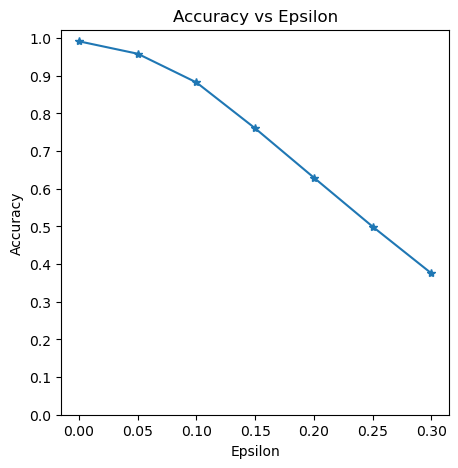

[0.9917, 0.9587, 0.8825, 0.7606, 0.6297, 0.4997, 0.3757]

In [15]:
## Accuracy vs Epsilon graph
plt.figure(figsize=(5,5))
plt.plot(epsilon_range, test_acc, '*-')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title('Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.show()

test_acc

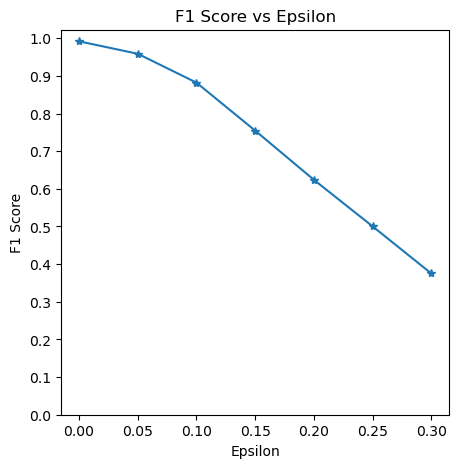

[0.991697354660609,
 0.9586631059679043,
 0.8820296766033611,
 0.754570206311432,
 0.6239613573564396,
 0.5003420126578024,
 0.37514015795690847]

In [16]:
## F1 Score vs Epsilon graph
plt.figure(figsize=(5,5))
plt.plot(epsilon_range, test_f1, '*-')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title('F1 Score vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('F1 Score')
plt.show()

test_f1

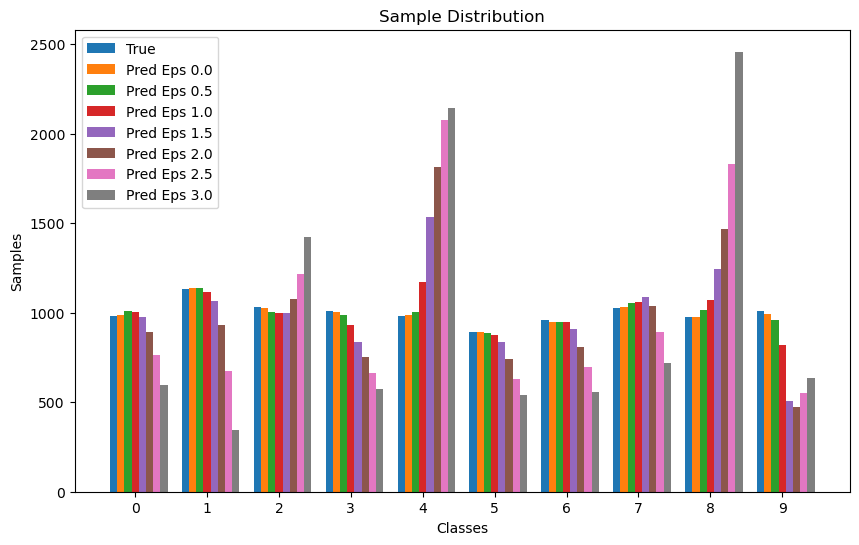

In [17]:
label_freq_true = [0] * 10
label_freq_pred = [None] * len(epsilon_range)
for i in range(len(epsilon_range)):
    label_freq_pred[i] = [0] * 10

for true, _, _, _ in samples[0]:
    label_freq_true[true] += 1
for i in range(len(epsilon_range)):
    for _, pred, _, _ in samples[i]:
        label_freq_pred[i][pred] += 1
        
sample_classes = np.arange(10)
width = 0.1
plt.figure(figsize=(10,6))

plt.bar(sample_classes, label_freq_true, width, label = 'True')
for i, eps in enumerate(range(len(epsilon_range))):
    plt.bar(sample_classes + width * (i + 1), label_freq_pred[i], width, label = f'Pred Eps {eps/2}')

plt.title(f'Sample Distribution')
plt.xlabel('Classes')
plt.ylabel('Samples')

plt.xticks(sample_classes + width * 3, sample_classes)
plt.legend(loc='best')
plt.show()

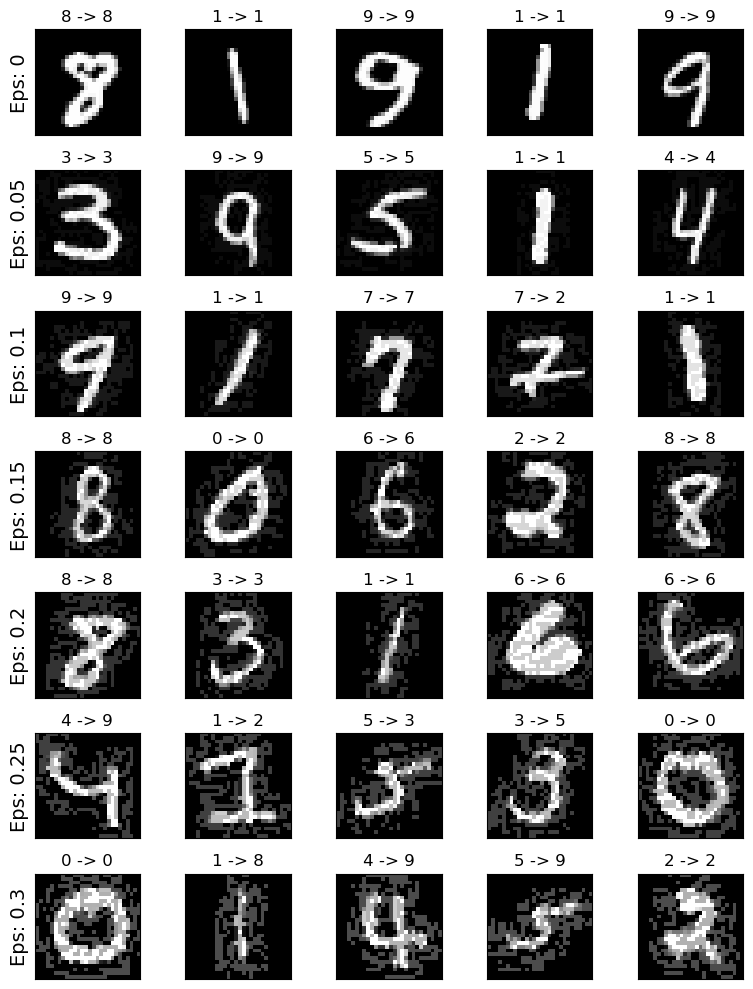

In [18]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8, 10))
for i in range(len(epsilon_range)):
    for j in range(5):
        cnt += 1
        plt.subplot(len(epsilon_range), 5, cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f'Eps: {epsilon_range[i]}', fontsize=14)
        true, pred, image, _ = samples[i][j]
        plt.title(f'{true} -> {pred}')
        plt.imshow(image, cmap='gray')
plt.tight_layout()
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

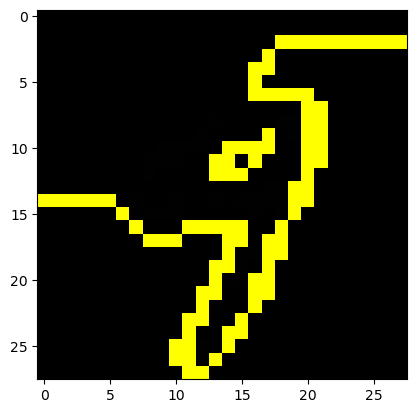

In [19]:
sample = samples[2][0]
get_explaination(sample)

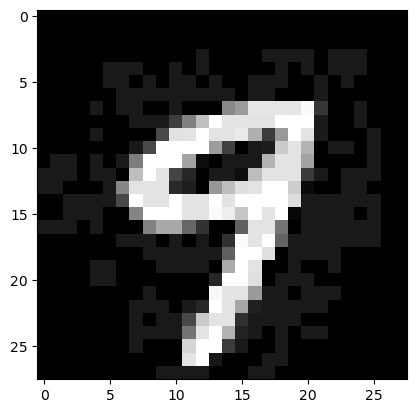

In [20]:
plt.imshow(sample[2], cmap='gray')

In [21]:
## Adversarially train model
train_loss = []
train_acc = []
train_f1 = []

for epoch in tqdm(range(epochs), desc='Training progress'):
    train_epoch(epsilon)

Training progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 train:   0%|          | 0/1875 [00:00<?, ?it/s]

Train epoch results:
Loss: 0.5310410353283087
Acc: 0.8425833333333334
F1: 0.8423662940767449


Epoch 2 train:   0%|          | 0/1875 [00:00<?, ?it/s]

Train epoch results:
Loss: 0.31486943885882696
Acc: 0.9050833333333334
F1: 0.9050121020993195


Epoch 3 train:   0%|          | 0/1875 [00:00<?, ?it/s]

Train epoch results:
Loss: 0.2556899182205399
Acc: 0.9213333333333333
F1: 0.9212899090915719


Epoch 4 train:   0%|          | 0/1875 [00:00<?, ?it/s]

Train epoch results:
Loss: 0.22715748005708059
Acc: 0.9298333333333333
F1: 0.9298023323556965


Epoch 5 train:   0%|          | 0/1875 [00:00<?, ?it/s]

Train epoch results:
Loss: 0.20842525238047044
Acc: 0.9359833333333333
F1: 0.9359822989589692


Epoch 6 train:   0%|          | 0/1875 [00:00<?, ?it/s]

Train epoch results:
Loss: 0.19703328595608474
Acc: 0.9390333333333334
F1: 0.93902494776907


Epoch 7 train:   0%|          | 0/1875 [00:00<?, ?it/s]

Train epoch results:
Loss: 0.18824359753131867
Acc: 0.9416833333333333
F1: 0.9416790607398623


Epoch 8 train:   0%|          | 0/1875 [00:00<?, ?it/s]

Train epoch results:
Loss: 0.17697201946104565
Acc: 0.9446833333333333
F1: 0.9446831822052358


Epoch 9 train:   0%|          | 0/1875 [00:00<?, ?it/s]

Train epoch results:
Loss: 0.162526101240019
Acc: 0.94985
F1: 0.9498436002006272


Epoch 10 train:   0%|          | 0/1875 [00:00<?, ?it/s]

Train epoch results:
Loss: 0.1467010664695253
Acc: 0.9538666666666666
F1: 0.9538651015116842


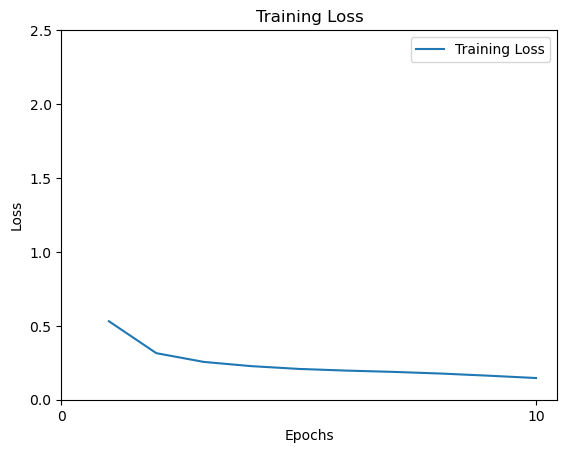

In [22]:
## Loss graph
plt.plot(range(1, epochs + 1), train_loss, label='Training Loss')
 
plt.title(f'Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.xticks(range(0, epochs + 1, 10))
plt.legend(loc='best')
plt.ylim(bottom=0, top=2.5)
plt.show()

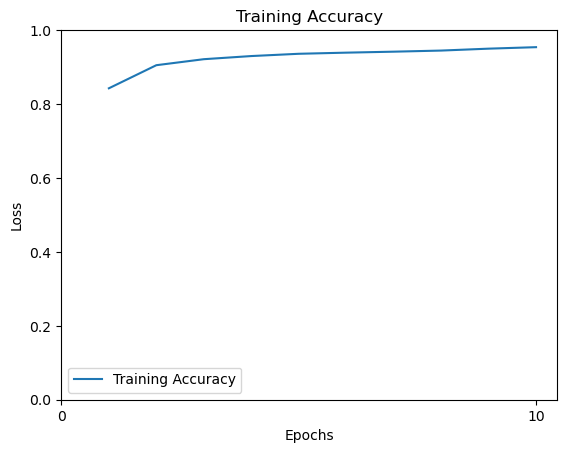

In [23]:
## Accuracy graph
plt.plot(range(1, epochs + 1), train_acc, label='Training Accuracy')

plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.xticks(range(0, epochs + 1, 10))
plt.legend(loc='best')
plt.ylim(bottom=0, top=1)
plt.show()

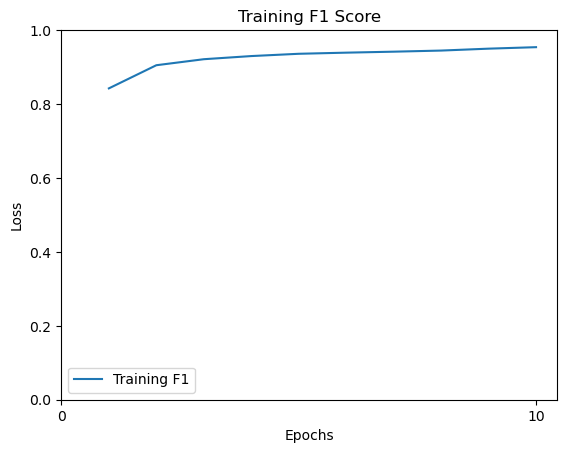

In [24]:
## F1 graph
plt.plot(range(1, epochs + 1), train_f1, label='Training F1')
 
plt.title('Training F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.xticks(range(0, epochs + 1, 10))
plt.legend(loc='best')
plt.ylim(bottom=0, top=1)
plt.show()

In [25]:
## Test Retrained model
test_loss = []
test_acc = []
test_f1 = []
samples = []

for eps in epsilon_range:
    test_epoch(eps)

Epsilon 0:   0%|          | 0/313 [00:00<?, ?it/s]

Test epoch results:
Loss: 0.040452941635791946
Acc: 0.9887
F1: 0.9887003372290183


Epsilon 0.05:   0%|          | 0/313 [00:00<?, ?it/s]

Test epoch results:
Loss: 0.0792482689630851
Acc: 0.9796
F1: 0.9795860566514984


Epsilon 0.1:   0%|          | 0/313 [00:00<?, ?it/s]

Test epoch results:
Loss: 0.07519978127835528
Acc: 0.9816
F1: 0.9815799527338366


Epsilon 0.15:   0%|          | 0/313 [00:00<?, ?it/s]

Test epoch results:
Loss: 0.06766180666938117
Acc: 0.983
F1: 0.9829813645081674


Epsilon 0.2:   0%|          | 0/313 [00:00<?, ?it/s]

Test epoch results:
Loss: 0.06416668950714084
Acc: 0.9827
F1: 0.9826869099266192


Epsilon 0.25:   0%|          | 0/313 [00:00<?, ?it/s]

Test epoch results:
Loss: 0.06485068974766349
Acc: 0.9807
F1: 0.980675400581119


Epsilon 0.3:   0%|          | 0/313 [00:00<?, ?it/s]

Test epoch results:
Loss: 0.06746935074480946
Acc: 0.9786
F1: 0.9785779247963204


In [26]:
test_loss

[0.040452941635791946,
 0.0792482689630851,
 0.07519978127835528,
 0.06766180666938117,
 0.06416668950714084,
 0.06485068974766349,
 0.06746935074480946]

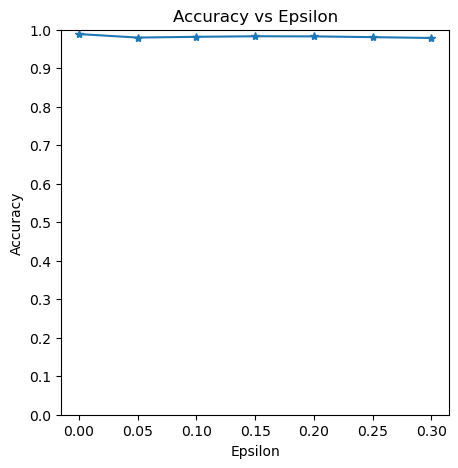

[0.9887, 0.9796, 0.9816, 0.983, 0.9827, 0.9807, 0.9786]

In [27]:
## Accuracy vs Epsilon graph
plt.figure(figsize=(5,5))
plt.plot(epsilon_range, test_acc, '*-')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title('Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.show()

test_acc

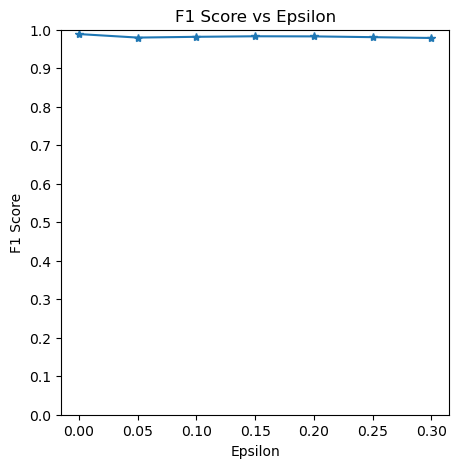

[0.9887003372290183,
 0.9795860566514984,
 0.9815799527338366,
 0.9829813645081674,
 0.9826869099266192,
 0.980675400581119,
 0.9785779247963204]

In [28]:
## F1 Score vs Epsilon graph
plt.figure(figsize=(5,5))
plt.plot(epsilon_range, test_f1, '*-')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title('F1 Score vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('F1 Score')
plt.show()

test_f1

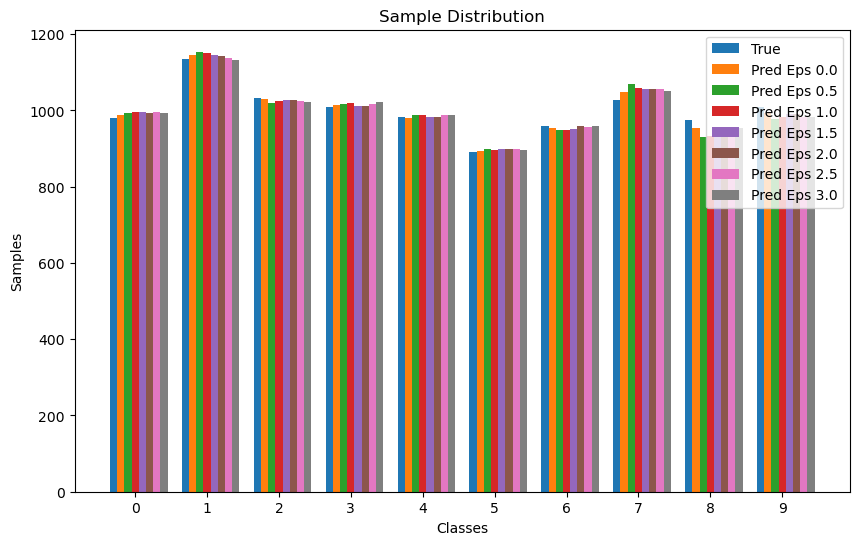

In [29]:
label_freq_true = [0] * 10
label_freq_pred = [None] * len(epsilon_range)
for i in range(len(epsilon_range)):
    label_freq_pred[i] = [0] * 10

for true, _, _, _ in samples[0]:
    label_freq_true[true] += 1
for i in range(len(epsilon_range)):
    for _, pred, _, _ in samples[i]:
        label_freq_pred[i][pred] += 1
        
sample_classes = np.arange(10)
width = 0.1
plt.figure(figsize=(10,6))

plt.bar(sample_classes, label_freq_true, width, label = 'True')
for i, eps in enumerate(range(len(epsilon_range))):
    plt.bar(sample_classes + width * (i + 1), label_freq_pred[i], width, label = f'Pred Eps {eps/2}')

plt.title(f'Sample Distribution')
plt.xlabel('Classes')
plt.ylabel('Samples')

plt.xticks(sample_classes + width * 3, sample_classes)
plt.legend(loc='best')
plt.show()

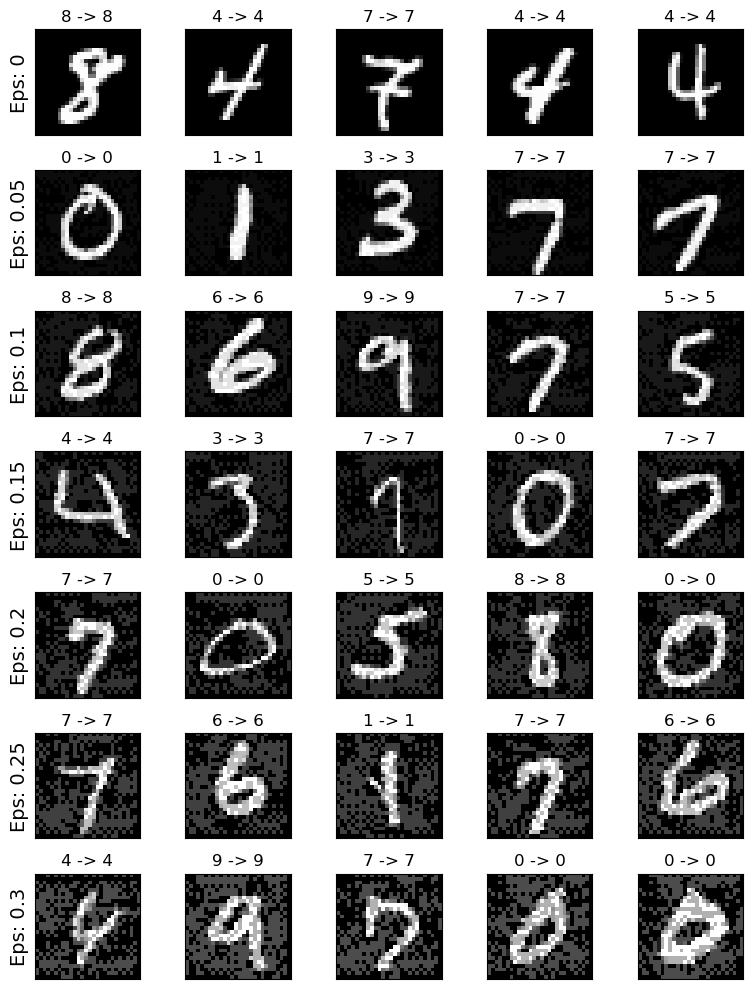

In [30]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8, 10))
for i in range(len(epsilon_range)):
    for j in range(5):
        cnt += 1
        plt.subplot(len(epsilon_range), 5, cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f'Eps: {epsilon_range[i]}', fontsize=14)
        true, pred, image, _ = samples[i][j]
        plt.title(f'{true} -> {pred}')
        plt.imshow(image, cmap='gray')
plt.tight_layout()
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

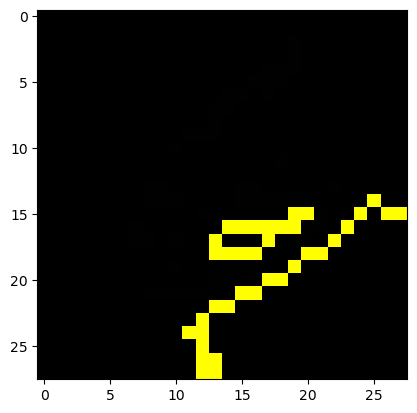

In [39]:
sample = samples[2][1]
get_explaination(sample)

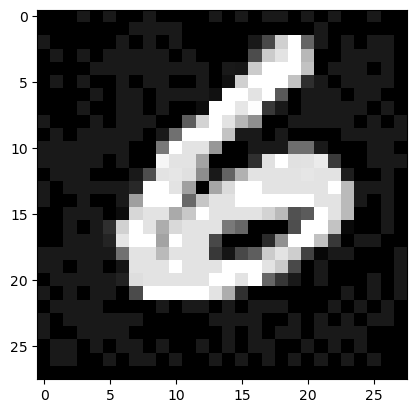

In [40]:
plt.imshow(sample[2], cmap='gray')